# Chapter 11 – Training Deep Neural Networks

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Vanishing/Exploding Gradients Problem

Looking at the logistic activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


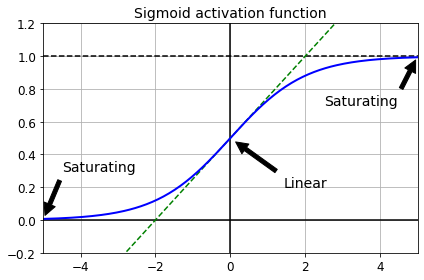

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

Figure 11-1. Logistic activation function saturation

### Glorot and He Initialization  

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the *fan-in* and *fan-out* of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in Equation 11-1, where 
$\text{fan}_{\text{avg}} = (\text{fan}_{\text{in}} + \text{fan}_{\text{out}})/2$. This initialization strategy is called *Xavier initialization* or *Glorot initialization*, after the paper’s first author. 

*Method of Glorot initialization* 

- Step 1: Initialize weights from Gaussian or uniform distribution
- Step 2: Scale the weights proportional to the number of inputs of the layer
(For the first hidden layer, that is the number of features in the dataset; for the second hidden layer, that is the number of units in the 1st hidden layer, etc.)

In particular, scale as follows:
$$\mathbf W^{(l)}:=\mathbf W^{(l)}\sqrt{\frac{1}{m^{(l-1)}}}$$ where $m$ is the number of features of input units to the next layer and $l$ is the layer index.

$$\begin{align}
\mathbb V(z_j^{(l)})&=\mathbb V\left(\sum_{k=1}^{m^{l-1}}W_{jk}^{(l)}a_k^{(l-1)}\right)\\
&=\sum_{k=1}^{m^{l-1}}\mathbb V\left[W_{jk}^{(l)}a_k^{(l-1)}\right]\\
&=\sum_{k=1}^{m^{l-1}}\mathbb V\left[W_{jk}^{(l)}\right]\mathbb V \left[a_k^{(l-1)}\right]\\
&=m^{(l-1)}\mathbb V\left[W^{(l)}\right]\mathbb V \left[a^{(l-1)}\right]\\
\end{align}$$

*Equation 11-1. Glorot initialization (when using the logistic activation function)*

$$\text{Normal distribution with mean 0 and variance } \sigma^2=\frac{1}{\text{fan}_{\text{avg}}}$$
$$\text{Or a uniform distribution between -r and +r, with } r=\sqrt{\frac{3}{\text{fan}_{\text{avg}}}}$$

If you replace $\text{fan}_{\text{avg}}$ with $\text{fan}_{\text{in}}$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it *LeCun initialization*. Genevieve Orr and Klaus-Robert Müller even recommended it in their 1998 book *Neural Networks: Tricks of the Trade* (Springer). LeCun initialization is equivalent to Glorot initialization when $\text{fan}_{\text{in}}=\text{fan}_{\text{out}}$. It took over a decade for researchers to realize how important this trick is. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning. 



*Table 11-1. Initialization parameters for each type of activation function*

| Initialization |Activation functions | $\sigma^2$ (Normal) |
| ----------- |----------- |----------- |
| Glorot |None, tanh, logistic, softmax | $1/\text{fan}_{\text{avg}}$ |
| He |ReLU and variants | $2/\text{fan}_{\text{in}}$ |
| LeCun |SELU | $1/\text{fan}_{\text{in}}$ |



In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` like this:

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on $\text{fan}_{\text{avg}}$ rather than $\text{fan}_{\text{in}}$, you can use the `VarianceScaling` initializer like this:

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### Nonsaturating Activation Functions

#### Leaky ReLU, randomized leaky ReLU (RReLU), and parametric leaky ReLU (PReLU)

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute).

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

To solve this problem, you may want to use a variant of the ReLU function, such as the *leaky ReLU*. This function is defined as $LeakyReLU_{\alpha}(z) = \max(\alpha z, z)$ (see Figure 11-2). The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for z < 0 and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. A 2015 paper compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function. In fact, setting $\alpha=0.2$ (a huge leak) seemed to result in better performance than $\alpha=0.01$ (a small leak). The paper also evaluated the *randomized leaky ReLU (RReLU)*, where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. *RReLU* also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set). Finally, the paper evaluated the *parametric leaky ReLU (PReLU)*, where $\alpha$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


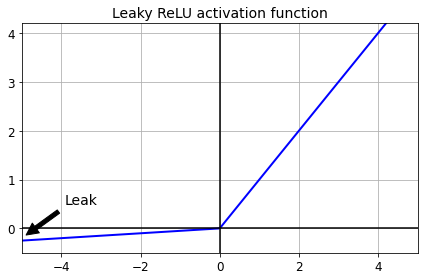

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Figure 11-2. Leaky ReLU: like ReLU, but with a small slope for negative values

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU: 

To use the leaky ReLU activation function, create a `LeakyReLU` layer and add it to your model just after the layer you want to apply it to:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6627 - accuracy: 0.4992 - val_loss: 0.9047 - val_accuracy: 0.7158
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8542 - accuracy: 0.7231 - val_loss: 0.7203 - val_accuracy: 0.7636
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7114 - accuracy: 0.7625 - val_loss: 0.6475 - val_accuracy: 0.7886
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6361 - accuracy: 0.7900 - val_loss: 0.5924 - val_accuracy: 0.8072
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6011 - accuracy: 0.8008 - val_loss: 0.5597 - val_accuracy: 0.8196
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5634 - accuracy: 0.8143 - val_loss: 0.5361 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5386 - accuracy: 0.8212 - val_loss: 0.5166 - val_accuracy:

Now let's try PReLU:
For PReLU, replace `LeakyRelu(alpha=0.2)` with `PReLU()`. There is currently no official implementation of RReLU in Keras, but you can fairly easily implement your own (to learn how to do that, see the exercises at the end of Chapter 12).


In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6969 - accuracy: 0.4974 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8706 - accuracy: 0.7247 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7211 - accuracy: 0.7621 - val_loss: 0.6564 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6447 - accuracy: 0.7879 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6077 - accuracy: 0.8004 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5692 - accuracy: 0.8118 - val_loss: 0.5406 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5428 - accuracy: 0.8194 - val_loss: 0.5196 - val_accuracy:

#### exponential linear unit (ELU)

Last but not least, a 2015 paper by Djork-Arné Clevert et al. proposed a new activation function called the *exponential linear unit (ELU)* that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set. Figure 11-3 graphs the function, and Equation 11-2 shows its definition.

*Equation 11-2. ELU activation function*

$$\text{ELU}_{\alpha}(z)=\begin{cases}
\alpha(\exp(z)-1) & \text{if } z<0\\
z & \text{if } z\ge 0\\
\end{cases}$$

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


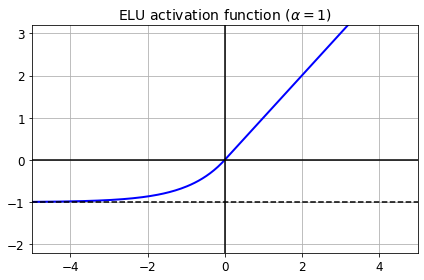

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Figure 11-3. ELU activation function

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

#### Scaled ELU (SELU)

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will *self-normalize*: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.  

a few conditions for self-normalization to happen (see the paper for the mathematical justification):

- The input features must be standardized (mean 0 and standard deviation 1).

- Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.

- The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks (see Chapter 15) or networks with *skip connections* (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.

- The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well (see Chapter 14). 

$$\alpha = \sqrt{2 / \pi} / \left(erfc(1/\sqrt{2}) \exp(1/2) - 1\right)$$
$$\text{scale}=\bigg[1 - erfc(1 / \sqrt{2}) \sqrt{e}\bigg] \sqrt{2 \pi}\bigg[2 erfc(\sqrt{2})e^2 + 
                                                                               \pi \cdot erfc(1/\sqrt{2})^2e - 
                                                                               2(2+\pi)erfc(1/\sqrt{2})\sqrt{e}+\pi+2\bigg]^{-1/2}$$

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi)*(2 * erfc(np.sqrt(2))*np.e**2 + 
                                                                               np.pi*erfc(1/np.sqrt(2))**2*np.e - 
                                                                               2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


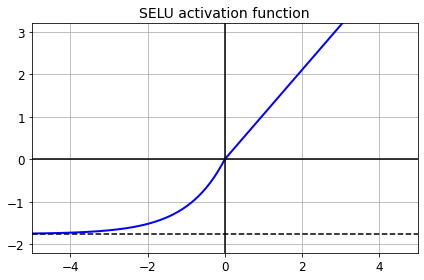

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization, scale is Standard deviation, then variance is 1/100 
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy: 

For SELU activation, set `activation="selu"` and `kernel_initializer="lecun_normal"` when creating a layer:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 18s 10ms/step - loss: 1.3846 - accuracy: 0.4696 - val_loss: 0.8607 - val_accuracy: 0.6844
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8137 - accuracy: 0.6976 - val_loss: 0.6269 - val_accuracy: 0.7816
Epoch 3/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6570 - accuracy: 0.7609 - val_loss: 0.5947 - val_accuracy: 0.7866
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5791 - accuracy: 0.7917 - val_loss: 0.5250 - val_accuracy: 0.8190
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5197 - accuracy: 0.8174 - val_loss: 0.4826 - val_accuracy: 0.8396


Now look at what happens if we try to use the ReLU activation function instead:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 16s 9ms/step - loss: 2.0610 - accuracy: 0.1872 - val_loss: 1.6005 - val_accuracy: 0.3170
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.2244 - accuracy: 0.4732 - val_loss: 1.2055 - val_accuracy: 0.5082
Epoch 3/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.0743 - accuracy: 0.5505 - val_loss: 0.8802 - val_accuracy: 0.6350
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8585 - accuracy: 0.6582 - val_loss: 0.7745 - val_accuracy: 0.7008
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7509 - accuracy: 0.6960 - val_loss: 0.8195 - val_accuracy: 0.6486


Not great at all, we suffered from the vanishing/exploding gradients problem.

### Batch Normalization



Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called *Batch Normalization (BN)* that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a `StandardScaler`); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized step by step in Equation 11-3.

*Equation 11-3. Batch Normalization algorithm*  

- 1. $$\boldsymbol\mu_{B}=\frac{1}{m_{B}}\sum_{1}^{m_{B}}\mathbf x^{(i)}$$
- 2. $$\boldsymbol\sigma^2_{B}=\frac{1}{m_{B}}\sum_{1}^{m_{B}}\left(\mathbf x^{(i)}-\boldsymbol\mu_{B}\right)^2$$
- 3. $$\hat{\mathbf x}^{(i)}=\frac{\mathbf x^{(i)}-\boldsymbol\mu_{B}}{\sqrt{\boldsymbol\sigma^2_{B}+\epsilon}}$$
- 4. $$\mathbf z^{(i)}=\boldsymbol\gamma\otimes \hat{\mathbf x}^{(i)}+\boldsymbol\beta$$

In this algorithm:

- $\boldsymbol\mu_{B}$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).
- $\boldsymbol\sigma_{B}$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).

- $m_{B}$ is the number of instances in the mini-batch.

- $\mathbf x^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.

- $\boldsymbol\gamma$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

- $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

- $\boldsymbol\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

- $\epsilon$ is a tiny number that avoids division by zero (typically $10^{-5}$). This is called a smoothing term.

- $\mathbf z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the `BatchNormalization` layer. To sum up, four parameter vectors are learned in each batch-normalized layer: $\boldsymbol\gamma$ (the output scale vector) and $\boldsymbol\beta$ (the output offset vector) are learned through regular backpropagation, and $\boldsymbol\mu$ (the final input mean vector) and $\boldsymbol\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average. Note that $\boldsymbol\mu$ and $\boldsymbol\sigma$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-3).  

Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it’s often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes $\mathbf X\mathbf W + \mathbf b$, then the BN layer will compute $\boldsymbol\gamma\otimes(\mathbf X\mathbf W + \mathbf b - \boldsymbol\mu)/\boldsymbol\sigma + \boldsymbol\beta$ (ignoring the smoothing term $\epsilon$ in the denominator). If we define $\mathbf W' = \boldsymbol\gamma\otimes\mathbf W/\boldsymbol\sigma$ and $\mathbf b' = \boldsymbol\gamma\otimes(\mathbf b - \boldsymbol\mu)/\boldsymbol\sigma + \boldsymbol\beta$, the equation simplifies to $\mathbf X\mathbf W' + \mathbf b'$. So if we replace the previous layer’s weights and biases ($\mathbf W$ and $\mathbf b$) with the updated weights and biases ($\mathbf W'$ and $\mathbf b'$), we can get rid of the BN layer (TFLite’s optimizer does this automatically; see Chapter 19).



### Implement batch normalization with keras

As with most things with Keras, implementing Batch Normalization is simple and intuitive. Just add a `BatchNormalization` layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model. For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [1]:
28*28, 28*28*4, # each input has 𝝁 , 𝝈 ,   𝜸 and 𝜷 4 parameters

(784, 3136)

In [2]:
(784+1)*300, 300*4, (300+1)*100, 100*4, (100+1)*10

(235500, 1200, 30100, 400, 1010)

As you can see, each BN layer adds four parameters per input: $\boldsymbol\gamma$, $\boldsymbol\beta$, $\boldsymbol\mu$, and $\boldsymbol\sigma$ (for example, the first BN layer adds 3,136 parameters, which is 4 × 784). The last two parameters, $\boldsymbol\mu$ and $\boldsymbol\sigma$, are the moving averages; they are not affected by backpropagation, so Keras calls them “non-trainable” (if you count the total number of BN parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total number of non-trainable parameters in this model).

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Now when you create a BN layer in Keras, it also creates two operations that will be called by Keras at each iteration during training. These operations will update the moving averages. Since we are using the TensorFlow backend, these operations are TensorFlow operations (we will discuss TF operations in Chapter 12):

In [38]:
#bn1.updates #deprecated
#model.layers[1].updates

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 1.2287 - accuracy: 0.5993 - val_loss: 0.5526 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5996 - accuracy: 0.7960 - val_loss: 0.4725 - val_accuracy: 0.8470
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5312 - accuracy: 0.8172 - val_loss: 0.4375 - val_accuracy: 0.8556
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4885 - accuracy: 0.8295 - val_loss: 0.4151 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4717 - accuracy: 0.8345 - val_loss: 0.3997 - val_accuracy: 0.8632
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4420 - accuracy: 0.8462 - val_loss: 0.3867 - val_accuracy: 0.8696
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4286 - accuracy: 0.8497 - val_loss: 0.3763 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3677 - accuracy: 0.5604 - val_loss: 0.6767 - val_accuracy: 0.7812
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7136 - accuracy: 0.7702 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6123 - accuracy: 0.7991 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5547 - accuracy: 0.8149 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5255 - accuracy: 0.8229 - val_loss: 0.4434 - val_accuracy: 0.8536
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4947 - accuracy: 0.8327 - val_loss: 0.4263 - val_accuracy: 0.8548
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4736 - accuracy: 0.8387 - val_loss: 0.4131 - val_accuracy:

The `BatchNormalization` class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the `momentum`. This hyperparameter is used by the `BatchNormalization` layer when it updates the exponential moving averages; given a new value $\mathbf v$(i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average $\hat{\mathbf v}$ using the following equation:

$$\hat{\mathbf v}\leftarrow\hat{\mathbf v}\times\text{momentum}+\mathbf v\times(1-\text{momentum})$$
A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you want more 9s for larger datasets and smaller mini-batches).  

Another important hyperparameter is axis: it determines which axis should be normalized. It defaults to $–1$, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes). When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch. For example, the first BN layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features. If we move the first BN layer before the Flatten layer, then the input batches will be 3D, with shape [batch size, height, width]; therefore, the BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set `axis=[1, 2]`.

Notice that the BN layer does not perform the same computation during training and after training: it uses batch statistics during training and the “final” statistics after training (i.e., the final values of the moving averages). Let’s take a peek at the source code of this class to see how this is handled:

In [44]:
class BatchNormalization(keras.layers.Layer):
    [...]
    def call(self, inputs, training=None):
        [...]

The `call()` method is the one that performs the computations; as you can see, it has an extra training argument, which is set to None by default, but the `fit()` method sets to it to 1 during training. If you ever need to write a custom layer, and it must behave differently during training and testing, add a training argument to the `call()` method and use this argument in the method to decide what to compute (we will discuss custom layers in Chapter 12).

`BatchNormalization` has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer. But a recent paper by Hongyi Zhang et al. may change this assumption: by using a novel fixed-update (fixup) weight initialization technique, the authors managed to train a very deep neural network (10,000 layers!) without BN, achieving state-of-the-art performance on complex image classification tasks. As this is bleeding-edge research, however, you may want to wait for additional research to confirm this finding before you drop Batch Normalization.

### Gradient Clipping  

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called Gradient Clipping. This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs, as we will see in Chapter 15. For other types of networks, BN is usually sufficient.

In Keras, implementing Gradient Clipping is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer, like this:

In [45]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [46]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0. The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its ℓ2 norm is greater than the threshold you picked. For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component. If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.

## Reusing Pretrained Layers

### Transfer Learning with Keras

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [47]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [48]:
X_train_A.shape

(43986, 28, 28)

In [49]:
X_train_B.shape

(200, 28, 28)

In [50]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [51]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

In [53]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [54]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [55]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.9249 - accuracy: 0.6994 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3651 - accuracy: 0.8745 - val_loss: 0.3288 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3182 - accuracy: 0.8897 - val_loss: 0.3013 - val_accuracy: 0.8991
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3048 - accuracy: 0.8954 - val_loss: 0.2896 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2804 - accuracy: 0.9029 - val_loss: 0.2773 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2701 - accuracy: 0.9075 - val_loss: 0.2735 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2627 - accuracy: 0.9093 - val_loss: 0.2721 - val_accuracy:

In [56]:
model_A.save("my_model_A.h5")

In [57]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [58]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [59]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 28ms/step - loss: 1.0360 - accuracy: 0.4975 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.5883 - accuracy: 0.6971 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4380 - accuracy: 0.8854 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4021 - accuracy: 0.8712 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3361 - accuracy: 0.9348 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3113 - accuracy: 0.9233 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 12ms/step - loss: 0.2817 - accuracy: 0.9299 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [60]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_225 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_226 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_227 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_228 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

Let’s look at an example. Suppose the Fashion MNIST dataset only contained eight classes—for example, all the classes except for sandal and shirt. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirt, negative=sandal). Your dataset is quite small; you only have 200 labeled images. When you train a new model for this task (let’s call it model B) with the same architecture as model A, it performs reasonably well (97.2% accuracy). But since it’s a much easier task (there are just two classes), you were hoping for more. While drinking your morning coffee, you realize that your task is quite similar to task A, so perhaps transfer learning can help? Let’s find out!

First, you need to load model A and create a new model based on that model’s layers. Let’s reuse all the layers except for the output layer:

In [61]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_A` and `model_B_on_A` now share some layers. When you train `model_B_on_A`, it will also affect `model_A`. If you want to avoid that, you need to clone `model_A` before you reuse its layers. To do this, you clone model A’s architecture with `clone_model()`, then copy its weights (since `clone_model()` does not clone the weights):

In [62]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Now you could train `model_B_on_A` for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s trainable attribute to False and compile the model:

In [63]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [64]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 27ms/step - loss: 0.6125 - accuracy: 0.6233 - val_loss: 0.5824 - val_accuracy: 0.6359
Epoch 2/4
7/7 [==============================] - 0s 11ms/step - loss: 0.5525 - accuracy: 0.6638 - val_loss: 0.5451 - val_accuracy: 0.6836
Epoch 3/4
7/7 [==============================] - 0s 11ms/step - loss: 0.4875 - accuracy: 0.7482 - val_loss: 0.5131 - val_accuracy: 0.7099
Epoch 4/4
7/7 [==============================] - 0s 12ms/step - loss: 0.4878 - accuracy: 0.7355 - val_loss: 0.4845 - val_accuracy: 0.7343
Epoch 1/16
7/7 [==============================] - 0s 27ms/step - loss: 0.4363 - accuracy: 0.7774 - val_loss: 0.3457 - val_accuracy: 0.8651
Epoch 2/16
7/7 [==============================] - 0s 11ms/step - loss: 0.2966 - accuracy: 0.9143 - val_loss: 0.2602 - val_accuracy: 0.9270
Epoch 3/16
7/7 [==============================] - 0s 12ms/step - loss: 0.2032 - accuracy: 0.9777 - val_loss: 0.2111 - val_accuracy: 0.9554
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [65]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [66]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 996us/step - loss: 0.0683 - accuracy: 0.9935


[0.06827671080827713, 0.9934999942779541]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.5!

In [67]:
(100 - 97.05) / (100 - 99.35)

4.538461538461503

## Faster Optimizers  

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using Batch Normalization, and reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer. In this section we will present the most popular algorithms: momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.

### Momentum optimization  

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind momentum optimization, proposed by Boris Polyak in 1964. In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

Recall that Gradient Descent updates the weights $\boldsymbol\theta$ by directly subtracting the gradient of the cost function $J(\boldsymbol\theta)$ with regard to the weights $(\nabla_{\boldsymbol\theta} J(\boldsymbol\theta))$ multiplied by the learning rate $\eta$. The equation is: $\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)$. It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient (multiplied by the learning rate $\eta$) from the *momentum vector* $\mathbf m$, and it updates the weights by adding this momentum vector (see Equation 11-4). In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the **momentum**, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9. 

*Equation 11-4. Momentum algorithm*  

$$\begin{align}
&1.\quad \mathbf m\leftarrow\beta \mathbf m-\eta\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\\
&2.\quad \boldsymbol\theta\leftarrow\boldsymbol\theta+\mathbf m
\end{align}$$ 

You can easily verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $\eta$ multiplied by $1/(1-\beta)$ (ignoring the sign). For example, if $\beta = 0.9$, then the terminal velocity is equal to 10 times the gradient times the learning rate, so momentum optimization ends up going 10 times faster than Gradient Descent! This allows momentum optimization to escape from plateaus much faster than Gradient Descent. We saw in Chapter 4 that when the inputs have very different scales, the cost function will look like an elongated bowl (see Figure 4-7). Gradient Descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum). In deep neural networks that don’t use Batch Normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.

Implementing momentum optimization in Keras is a no-brainer: just use the `SGD` optimizer and set its momentum hyperparameter, then lie back and profit!

In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### Nesterov Accelerated Gradient   

One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla momentum optimization. The *Nesterov Accelerated Gradient* (NAG) method, also known as *Nesterov momentum optimization*, measures the gradient of the cost function not at the local position $\boldsymbol\theta$ but slightly ahead in the direction of the momentum, at $\boldsymbol\theta + \beta\mathbf m$ (see Equation 11-5).

*Equation 11-5. Nesterov Accelerated Gradient algorithm*  

$$\begin{align}
&1.\quad \mathbf m\leftarrow\beta \mathbf m-\eta\nabla_{\boldsymbol\theta} J(\boldsymbol\theta+\beta \mathbf m)\\
&2.\quad \boldsymbol\theta\leftarrow\boldsymbol\theta+\mathbf m
\end{align}$$ 


This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in Figure 11-6 (where $\nabla_1$ represents the gradient of the cost function measured at the starting point $\boldsymbol\theta$, and $\nabla_2$ represents the gradient at the point located at $\boldsymbol\theta+\beta \mathbf m$).

As you can see, the Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, $\nabla_1$ continues to push farther across the valley, while $\nabla_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

NAG is generally faster than regular momentum optimization. To use it, simply set `nesterov=True` when creating the `SGD` optimizer:

<img src="./chapters/11/11.6.png" width = 600>
<div style="text-align:center"> Figure 11-6. Regular versus Nesterov momentum optimization: the former applies the gradients computed before the momentum step, while the latter applies the gradients computed after </div>

In [69]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad  

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The AdaGrad algorithm achieves this correction by scaling down the gradient vector along the steepest dimensions (see Equation 11-6).

*Equation 11-6. AdaGrad algorithm* 


$$\begin{align}
&1.\quad \mathbf s\leftarrow\mathbf s+\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\otimes\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\\
&2.\quad \boldsymbol\theta\leftarrow\boldsymbol\theta-\eta\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)⊘\sqrt{\mathbf s+\epsilon}
\end{align}$$ 

The first step accumulates the square of the gradients into the vector s (recall that the $\otimes$ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i \leftarrow s_i + (\partial J(\boldsymbol\theta) / \partial \theta_i)^2$ for each element $s_i$ of the vector $\mathbf s$; in other words, each $s_i$ accumulates the squares of the partial derivative of the cost function with regard to parameter $\theta_i$. If the cost function is steep along the $i^{th}$ dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector is scaled down by a factor of $\sqrt{\mathbf s+\epsilon}$ (the ⊘ symbol represents the element-wise division, and $\epsilon$ is a smoothing term to avoid division by zero, typically set to $10^{-10}$). This vectorized form is equivalent to simultaneously computing $$\theta_i\leftarrow \theta_i-\eta \frac{\partial J(\boldsymbol\theta)/\partial \theta_i}{\sqrt{s_i+\epsilon}}$$ for all parameters $\theta_i$.

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum (see Figure 11-7). One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.  

<img src="./chapters/11/11.7.png" width = 600>
<div style="text-align:left"> Figure 11-7. AdaGrad versus Gradient Descent: the former can correct its direction earlier to point to the optimum </div>

AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an `Adagrad` optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though). Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate optimizers.

In [70]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### RMSProp  

As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The *RMSProp* algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step (see Equation 11-7).

*Equation 11-7. RMSProp algorithm* 

$$\begin{align}
&1.\quad \mathbf s\leftarrow\beta\mathbf s+(1-\beta)\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\otimes\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\\
&2.\quad \boldsymbol\theta\leftarrow\boldsymbol\theta-\eta\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)⊘\sqrt{\mathbf s+\epsilon}
\end{align}$$ 


The decay rate $\beta$ is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

As you might expect, Keras has an `RMSprop` optimizer:

In [71]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

Note that the `rho` argument corresponds to $\beta$ in Equation 11-7. Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

### Adam Optimization  

Adam, which stands for *adaptive moment estimation*, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients (see Equation 11-8).

*Equation 11-8. Adam algorithm*  

$$\begin{align}
&1.\quad \mathbf m\leftarrow\beta_1\mathbf m+(1-\beta_1)\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\\
&2.\quad \mathbf s\leftarrow\beta_2\mathbf s+(1-\beta_2)\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\otimes\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\\
&3.\quad \widehat{\mathbf m}\leftarrow \frac{\mathbf m}{1-\beta_1^t}\\
&4. \quad \widehat{\mathbf s}\leftarrow \frac{\mathbf s}{1-\beta_2^t}\\
&5.\quad \boldsymbol\theta\leftarrow\boldsymbol\theta+\eta\widehat{\mathbf m}⊘\sqrt{\hat{\mathbf s}+\epsilon}\\
\end{align}$$ 

In this equation, t represents the iteration number (starting at 1).

If you just look at steps 1, 2, and 5, you will notice Adam’s close similarity to both momentum optimization and RMSProp. The only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just 1 – β1 times the decaying sum). Steps 3 and 4 are somewhat of a technical detail: since $\mathbf m$ and $\mathbf s$ are initialized at 0, they will be biased toward 0 at the beginning of training, so these two steps will help boost $\mathbf m$ and $\mathbf s$ at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{-7}$. These are the default values for the Adam class (to be precise, epsilon defaults to None, which tells Keras to use `keras.backend.epsilon()`, which defaults to $10^{-7}$; you can change it using `keras.backend.set_epsilon()`). Here is how to create an Adam optimizer using Keras:

In [72]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta = 0.001$, making Adam even easier to use than Gradient Descent.

### Adamax Optimization  

Notice that in step 2 of Equation 11-8. $$2.\quad \mathbf s\leftarrow\beta_2\mathbf s+(1-\beta_2)\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)\otimes\nabla_{\boldsymbol\theta} J(\boldsymbol\theta)$$ Adam accumulates the squares of the gradients in $\mathbf s$ (with a greater weight for more recent gradients). In step 5, if we ignore $\epsilon$ and steps 3 and 4 (which are technical details anyway), Adam scales down the parameter updates by the square root of $\mathbf s$. In short, Adam scales down the parameter updates by the $\ell_2$ norm of the time-decayed gradients (recall that the $\ell_2$ norm is the square root of the sum of squares). AdaMax, introduced in the same paper as Adam, replaces the $\ell_2$ norm with the $\ell_{\infty}$ norm (a fancy way of saying the max). Specifically, it replaces step 2 in Equation 11-8 with $$\mathbf s \leftarrow \max (\beta_2\mathbf s,\nabla_{\boldsymbol\theta} J(\boldsymbol\theta))$$, it drops step 4, and in step 5 it scales down the gradient updates by a factor of $\mathbf s$, which is just the max of the time-decayed gradients. In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset, and in general Adam performs better. So, this is just one more optimizer you can try if you experience problems with Adam on some task.

In [73]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

### Nadam Optimization

In [74]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling  

Finding a good learning rate is very important. If you set it much too high, training may diverge (as we discussed in “Gradient Descent”). If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution (see Figure 11-8).  


<img src="./chapters/11/11.8.png" width = 600>
<div style="text-align:left"> Figure 11-8. Learning curves for various learning rates $\eta$ </div>

### Power Scheduling  

Set the learning rate to a function of the iteration number t: $\eta(t) = \eta_0 / (1 + t/s)^c$. The initial learning rate $\eta_0$, the power c (typically set to 1), and the steps s are hyperparameters. The learning rate drops at each step. After s steps, it is down to $\eta_0 / 2$. After s more steps, it is down to $\eta_0 / 3$, then it goes down to $\eta_0 / 4$, then $\eta_0/ 5$, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning $\eta_0$ and s (and possibly c).

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

Implementing power scheduling in Keras is the easiest option: just set the `decay` hyperparameter when creating an optimizer:

In [75]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

The decay is the inverse of s (the number of steps it takes to divide the learning rate by one more unit), and Keras assumes that c is equal to 1.

In [76]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [77]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5980 - accuracy: 0.7933 - val_loss: 0.4031 - val_accuracy: 0.8598
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3829 - accuracy: 0.8636 - val_loss: 0.3714 - val_accuracy: 0.8720
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3491 - accuracy: 0.8772 - val_loss: 0.3749 - val_accuracy: 0.8738
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3276 - accuracy: 0.8814 - val_loss: 0.3501 - val_accuracy: 0.8800
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3172 - accuracy: 0.8856 - val_loss: 0.3452 - val_accuracy: 0.8776
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2922 - accuracy: 0.8941 - val_loss: 0.3419 - val_accuracy: 0.8828
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2870 - accuracy: 0.8973 - val_loss: 0.3362 - val_accuracy:

In [80]:
np.arange(n_epochs)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

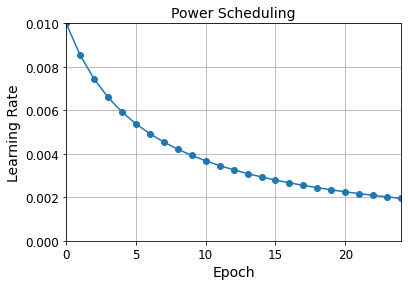

In [81]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling  

Set the learning rate to $\eta(t) = \eta_0 0.1^{t/s}$. The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

```lr = lr0 * 0.1**(epoch / s)```

Exponential scheduling and piecewise scheduling are quite simple too. You first need to define a function that takes the current epoch and returns the learning rate. For example, let’s implement exponential scheduling:

In [82]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

If you do not want to hardcode $\eta_0$ and s, you can create a function that returns a configured function:

In [83]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

Next, create a `LearningRateScheduler` callback, giving it the schedule function, and pass this callback to the `fit()` method:

The `LearningRateScheduler` will update the optimizer’s `learning_rate` attribute at the beginning of each epoch. Updating the learning rate once per epoch is usually enough, but if you want it to be updated more often, for example at every step, you can always write your own callback (see the “Exponential Scheduling” section of the notebook for an example). Updating the learning rate at every step makes sense if there are many steps per epoch. Alternatively, you can use the `keras.optimizers.schedules` approach, described shortly.

In [85]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1262 - accuracy: 0.7299 - val_loss: 0.7363 - val_accuracy: 0.7816
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6396 - accuracy: 0.7983 - val_loss: 0.6717 - val_accuracy: 0.7776
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5940 - accuracy: 0.8152 - val_loss: 0.6683 - val_accuracy: 0.7756
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5585 - accuracy: 0.8264 - val_loss: 0.6302 - val_accuracy: 0.8280
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5902 - accuracy: 0.8251 - val_loss: 0.5702 - val_accuracy: 0.8428
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4976 - accuracy: 0.8499 - val_loss: 0.5998 - val_accuracy: 0.8502
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4467 - accuracy: 0.8681 - val_loss: 0.5539 - val_accuracy:

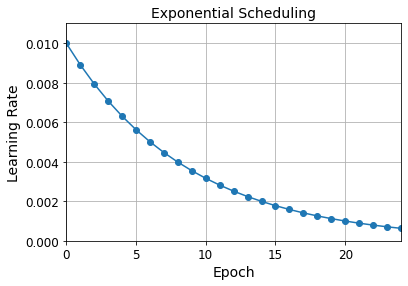

In [86]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can optionally take the current learning rate as a second argument. For example, the following schedule function multiplies the previous learning rate by $0.1^{1/20}$, which results in the same exponential decay (except the decay now starts at the beginning of epoch 0 instead of 1):

In [87]:
0.1**(1 / 20)

0.8912509381337456

In [88]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [89]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 1.1031 - accuracy: 0.7406 - val_loss: 0.7370 - val_accuracy: 0.7628
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6589 - accuracy: 0.7992 - val_loss: 0.5055 - val_accuracy: 0.8266
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5647 - accuracy: 0.8220 - val_loss: 0.6345 - val_accuracy: 0.8070
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5423 - accuracy: 0.8338 - val_loss: 0.5475 - val_accuracy: 0.8280
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4814 - accuracy: 0.8446 - val_loss: 0.4437 - val_accuracy: 0.8726
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4316 - accuracy: 0.8649 - val_loss: 0.4204 - val_accuracy: 0.8652
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3835 - accuracy: 0.8740 - val_loss: 0.4548 - val_accuracy:

In [90]:
len(X_train) // 32

1718

In [91]:
n_epochs

25

In [92]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

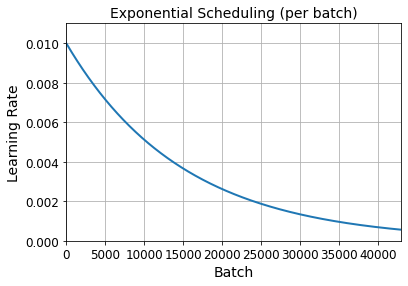

In [93]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling  

Use a constant learning rate for a number of epochs (e.g., $\eta_0 = 0.1$ for 5 epochs), then a smaller learning rate for another number of epochs (e.g., $\eta_1 = 0.001$ for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

For piecewise constant scheduling, you can use a schedule function like the following one (as earlier, you can define a more general function if you want), then create a `LearningRateScheduler` callback with this function and pass it to the `fit()` method, just like we did for exponential scheduling:

In [94]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [95]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [96]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1501 - accuracy: 0.7354 - val_loss: 0.9740 - val_accuracy: 0.7116
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8129 - accuracy: 0.7569 - val_loss: 0.9948 - val_accuracy: 0.7610
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0185 - accuracy: 0.7000 - val_loss: 1.3618 - val_accuracy: 0.6616
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9635 - accuracy: 0.6890 - val_loss: 0.7775 - val_accuracy: 0.7446
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8876 - accuracy: 0.7321 - val_loss: 0.9283 - val_accuracy: 0.7594
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6258 - accuracy: 0.8127 - val_loss: 0.6493 - val_accuracy: 0.8222
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5382 - accuracy: 0.8410 - val_loss: 0.6165 - val_accuracy:

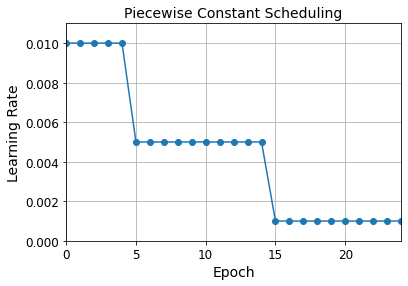

In [97]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling  

Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

For performance scheduling, use the `ReduceLROnPlateau` callback. For example, if you pass the following callback to the `fit()` method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs (other options are available; please check the documentation for more details):  


In [98]:
tf.random.set_seed(42)
np.random.seed(42)

In [99]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7106 - accuracy: 0.7771 - val_loss: 0.5125 - val_accuracy: 0.8486
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4918 - accuracy: 0.8382 - val_loss: 0.6228 - val_accuracy: 0.8306
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5085 - accuracy: 0.8422 - val_loss: 0.4834 - val_accuracy: 0.8558
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5015 - accuracy: 0.8487 - val_loss: 0.5006 - val_accuracy: 0.8514
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5169 - accuracy: 0.8465 - val_loss: 0.6444 - val_accuracy: 0.8280
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4875 - accuracy: 0.8577 - val_loss: 0.5703 - val_accuracy: 0.8554
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5200 - accuracy: 0.8564 - val_loss: 0.6182 - val_accuracy:

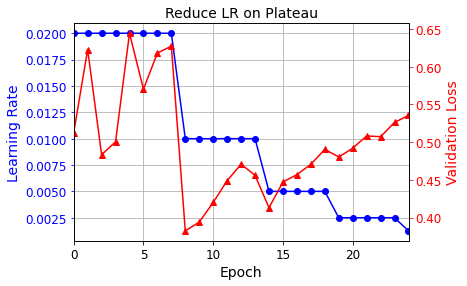

In [100]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers   

Lastly, tf.keras offers an alternative way to implement learning rate scheduling: define the learning rate using one of the schedules available in `keras.optimizers.schedules`, then pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example, here is how to implement the same exponential schedule as the `exponential_decay_fn()` function we defined earlier:

In [101]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5995 - accuracy: 0.7924 - val_loss: 0.4094 - val_accuracy: 0.8598
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3889 - accuracy: 0.8613 - val_loss: 0.3739 - val_accuracy: 0.8694
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3530 - accuracy: 0.8775 - val_loss: 0.3728 - val_accuracy: 0.8694
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3296 - accuracy: 0.8814 - val_loss: 0.3492 - val_accuracy: 0.8810
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3177 - accuracy: 0.8867 - val_loss: 0.3429 - val_accuracy: 0.8796
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2929 - accuracy: 0.8957 - val_loss: 0.3411 - val_accuracy: 0.8826
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2853 - accuracy: 0.8989 - val_loss: 0.3352 - val_accuracy:

For piecewise constant scheduling, try this:

In [102]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling  

Contrary to the other approaches, 1cycle (introduced in a 2018 paper by Leslie Smith) starts by increasing the initial learning rate $\eta_0$, growing linearly up to $\eta_1$ halfway through training. Then it decreases the learning rate linearly down to $\eta_0$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate $\eta_1$ is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate $\eta_0$ is chosen to be roughly 10 times lower. When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture).

As for the 1cycle approach, the implementation poses no particular difficulty: just create a custom callback that modifies the learning rate at each iteration (you can update the optimizer’s learning rate by changing `self.model.optimizer.lr`).
To sum up, exponential decay, performance scheduling, and 1cycle can considerably speed up convergence, so give them a try!

In [103]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
```

In [104]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.3117


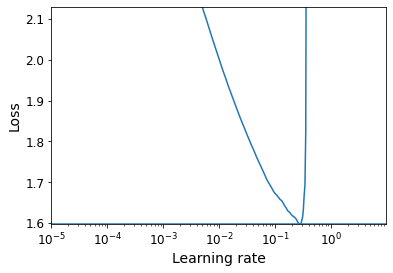

In [105]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [106]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [107]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4122 - accuracy: 0.8545 - val_loss: 0.4115 - val_accuracy: 0.8582
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.3869 - val_accuracy: 0.8688
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.8717 - val_loss: 0.3765 - val_accuracy: 0.8684
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3457 - accuracy: 0.8775 - val_loss: 0.3743 - val_accuracy: 0.8698
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8809 - val_loss: 0.3633 - val_accuracy: 0.8706
Epoch 

## Avoiding Overfitting Through Regularization  

We already implemented one of the best regularization techniques in Chapter 10: early stopping. Moreover, even though Batch Normalization was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer. In this section we will examine other popular regularization techniques for neural networks: $\ell_1$ and $\ell_2$ regularization, dropout, and max-norm regularization.

### $\ell_1$ and $\ell_2$ regularization  

Just like you did in Chapter 4 for simple linear models, you can use $\ell_2$ regularization to constrain a neural network’s connection weights, and/or $\ell_1$ regularization if you want a sparse model (with many weights equal to 0). Here is how to apply $\ell_2$ regularization to a Keras layer’s connection weights, using a regularization factor of 0.01:

In [108]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [109]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.2189 - accuracy: 0.7967 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7280 - accuracy: 0.8247 - val_loss: 0.6850 - val_accuracy: 0.8376


The `l2()` function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. As you might expect, you can just use `keras.regularizers.l1()` if you want $\ell_1$ regularization; if you want both $\ell_1$ and $\ell_2$ regularization, use `keras.regularizers.l1_l2()` (specifying both regularization factors).

Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s `functools.partial()` function, which lets you create a thin wrapper for any callable, with some default argument values:

In [110]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.2911 - accuracy: 0.7924 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7282 - accuracy: 0.8245 - val_loss: 0.6826 - val_accuracy: 0.8382


### Dropout  

Dropout is one of the most popular regularization techniques for deep neural networks. It was proposed in a paper by Geoffrey Hinton in 2012 and further detailed in a 2014 paper by Nitish Srivastava et al., and it has proven to be highly successful: even the state-of-the-art neural networks get a 1–2% accuracy boost simply by adding dropout. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step (see Figure 11-9). The hyperparameter $p$ is called the dropout rate, and it is typically set between 10% and 50%: closer to 20–30% in recurrent neural nets (see Chapter 15), and closer to 40–50% in convolutional neural networks (see Chapter 14). After training, neurons don’t get dropped anymore. And that’s all (except for a technical detail we will discuss momentarily).  

<img src="./chapters/11/11.9.png" width = 600>
<div style="text-align:left"> Figure 11-9. With dropout regularization, at each training iteration a random subset of all neurons in one or more layers—except the output layer—are “dropped out”; these neurons output 0 at this iteration (represented by the dashed arrows) </div>

It’s surprising at first that this destructive technique works at all. Would a company perform better if its employees were told to toss a coin every morning to decide whether or not to go to work? Well, who knows; perhaps it would! The company would be forced to adapt its organization; it could not rely on any single person to work the coffee machine or perform any other critical tasks, so this expertise would have to be spread across several people. Employees would have to learn to cooperate with many of their coworkers, not just a handful of them. The company would become much more resilient. If one person quit, it wouldn’t make much of a difference. It’s unclear whether this idea would actually work for companies, but it certainly does for neural networks. Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there are a total of $2^N$ possible networks (where N is the total number of droppable neurons). This is such a huge number that it is virtually impossible for the same neural network to be sampled twice. Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks (each with just one training instance). These neural networks are obviously not independent because they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.  

>In practice, you can usually apply dropout only to the neurons in the top one to three layers (excluding the output layer).


There is one small but important technical detail. Suppose $p = 50%$, in which case during testing a neuron would be connected to twice as many input neurons as it would be (on average) during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training. If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on and will be unlikely to perform well. More generally, we need to multiply each input connection weight by the keep probability $(1 – p)$ after training. Alternatively, we can divide each neuron’s output by the keep probability during training (these alternatives are not perfectly equivalent, but they work equally well).

To implement dropout using Keras, you can use the `keras.layers.Dropout` layer. During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability. After training, it does nothing at all; it just passes the inputs to the next layer. The following code applies dropout regularization before every Dense layer, using a dropout rate of 0.2:

In [111]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7611 - accuracy: 0.7576 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4306 - accuracy: 0.8401 - val_loss: 0.3395 - val_accuracy: 0.8718


Since dropout is only active during training, comparing the training loss and the validation loss can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So make sure to evaluate the training loss without dropout (e.g., after training).

### Alpha Dropout  

If you want to regularize a self-normalizing network based on the SELU activation function (as discussed earlier), you should use *alpha dropout*: this is a variant of dropout that preserves the mean and standard deviation of its inputs (it was introduced in the same paper as SELU, as regular dropout would break self-normalization).

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

In [113]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8023 - accuracy: 0.7146 - val_loss: 0.5778 - val_accuracy: 0.8446
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5662 - accuracy: 0.7903 - val_loss: 0.5160 - val_accuracy: 0.8518
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5260 - accuracy: 0.8058 - val_loss: 0.4899 - val_accuracy: 0.8610
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5129 - accuracy: 0.8093 - val_loss: 0.4766 - val_accuracy: 0.8592
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5073 - accuracy: 0.8119 - val_loss: 0.4237 - val_accuracy: 0.8710
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4784 - accuracy: 0.8208 - val_loss: 0.4614 - val_accuracy: 0.8636
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4720 - accuracy: 0.8266 - val_loss: 0.4725 - val_accuracy:

In [114]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 973us/step - loss: 0.4711 - accuracy: 0.8586


[0.47112908959388733, 0.8586000204086304]

In [115]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 977us/step - loss: 0.3488 - accuracy: 0.8823


[0.34875163435935974, 0.8822908997535706]

In [116]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.4229 - accuracy: 0.8433


### MC Dropout  

In 2016, a paper by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout:

- First, the paper established a profound connection between dropout networks (i.e., neural networks containing a `Dropout` layer before every weight layer) and approximate Bayesian inference, giving dropout a solid mathematical justification.

- Second, the authors introduced a powerful technique called *MC Dropout*, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all, provides a much better measure of the model’s uncertainty, and is also amazingly simple to implement.

If this all sounds like a “one weird trick” advertisement, then take a look at the following code. It is the full implementation of *MC Dropout*, boosting the dropout model we trained earlier without retraining it:

In [117]:
tf.random.set_seed(42)
np.random.seed(42)

In [118]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

We just make 100 predictions over the test set, setting `training=True` to ensure that the `Dropout` layer is active, and stack the predictions. Since dropout is active, all the predictions will be different. Recall that `predict()` returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so `y_probas` is an array of shape [100, 10000, 10]. Once we average over the first dimension (`axis=0`), we get `y_proba`, an array of shape [10000, 10], like we would get with a single prediction. That’s all! Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off. For example, let’s look at the model’s prediction for the first instance in the Fashion MNIST test set, with dropout off:

In [119]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],
      dtype=float32)

The model seems almost certain that this image belongs to class 9 (ankle boot). Should you trust it? Is there really so little room for doubt? Compare this with the predictions made when dropout is activated:

In [120]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.83, 0.  , 0.14]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.96, 0.  , 0.03]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.6 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.62, 0.  , 0.38]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.39, 0.  , 0.52]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.39, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.62, 0.  , 0.12, 0.  , 0.26]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.22, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.22, 0.  , 0.39]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.31, 0.  , 0.65]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.26, 0.  , 0

This tells a very different story: apparently, when we activate dropout, the model is not sure anymore. It still seems to prefer class 9, but sometimes it hesitates with classes 5 (sandal) and 7 (sneaker), which makes sense given they’re all footwear. Once we average over the first dimension, we get the following MC Dropout predictions:

In [121]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.23, 0.  , 0.68]],
      dtype=float32)

The model still thinks this image belongs to class 9, but only with a 62% confidence, which seems much more reasonable than 99%. Plus it’s useful to know exactly which other classes it thinks are likely. And you can also take a look at the standard deviation of the probability estimates:

In [122]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.22, 0.  , 0.27]],
      dtype=float32)

Apparently there’s quite a lot of variance in the probability estimates: if you were building a risk-sensitive system (e.g., a medical or financial system), you should probably treat such an uncertain prediction with extreme caution. You definitely would not treat it like a 99% confident prediction.

In [123]:
y_pred = np.argmax(y_proba, axis=1)

In [124]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8665

If your model contains other layers that behave in a special way during training (such as `BatchNormalization` layers), then you should not force training mode like we just did. Instead, you should replace the `Dropout` layers with the following `MCDropout` class:

In [125]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Here, we just subclass the `Dropout` layer and override the `call()` method to force its training argument to `True` (see Chapter 12). Similarly, you could define an `MCAlphaDropout` class by subclassing `AlphaDropout` instead. If you are creating a model from scratch, it’s just a matter of using `MCDropout` rather than `Dropout`. But if you have a model that was already trained using Dropout, you need to create a new model that’s identical to the existing model except that it replaces the `Dropout` layers with `MCDropout`, then copy the existing model’s weights to your new model.

In short, MC Dropout is a fantastic technique that boosts dropout models and provides better uncertainty estimates. And of course, since it is just regular dropout during training, it also acts like a regularizer.

In [126]:
tf.random.set_seed(42)
np.random.seed(42)

In [127]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [128]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [129]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [130]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [131]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.26, 0.  , 0.62]],
      dtype=float32)

### Max norm  

Another regularization technique that is popular for neural networks is called *max-norm regularization*: for each neuron, it constrains the weights $\mathbf w$ of the incoming connections such that $\lVert\mathbf w \rVert_2 \le r$, where r is the max-norm hyperparameter and $\lVert\cdot \rVert_2$ is the $\ell_2$ norm.

Max-norm regularization does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing $\lVert\mathbf w \rVert_2$ after each training step and rescaling $\mathbf w$ if needed ($\mathbf w \leftarrow\mathbf w r/\lVert\mathbf w \rVert_2$).

Reducing r increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the unstable gradients problems (if you are not using Batch Normalization).

To implement max-norm regularization in Keras, set the `kernel_constraint` argument of each hidden layer to a `max_norm()` constraint with the appropriate max value, like this:

In [132]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [133]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5756 - accuracy: 0.8027 - val_loss: 0.3776 - val_accuracy: 0.8654
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3545 - accuracy: 0.8699 - val_loss: 0.3746 - val_accuracy: 0.8714


After each training iteration, the model’s `fit()` method will call the object returned by `max_norm()`, passing it the layer’s weights and getting rescaled weights in return, which then replace the layer’s weights. As you’ll see in Chapter 12, you can define your own custom constraint function if necessary and use it as the `kernel_constraint`. You can also constrain the bias terms by setting the `bias_constraint` argument.

The `max_norm()` function has an axis argument that defaults to 0. A Dense layer usually has weights of shape [number of inputs, number of neurons], so using `axis=0` means that the max-norm constraint will apply independently to each neuron’s weight vector. If you want to use max-norm with convolutional layers (see Chapter 14), make sure to set the `max_norm()` constraint’s axis argument appropriately (usually axis=[0, 1, 2]).

## Summary and Practical Guidelines

*Table 11-3. Default DNN configuration* 

| Hyperparameter      | Default value |
| ----------- | ----------- |
| Kernel initializer      | He initialization       |
| Activation function   | ELU        |
| Normalization   | None if shallow; Batch Norm if deep        |
| Regularization   | Early stopping ($+\ell_2$ reg. if needed)        |
| Optimizer   | Momentum optimization (or RMSProp or Nadam)        |
| Learning rate schedule   | 1cycle       |  


If the network is a simple stack of dense layers, then it can self-normalize, and you should use the configuration in Table 11-4 instead.

*Table 11-4. DNN configuration for a self-normalizing net* 

| Hyperparameter      | Default value |
| ----------- | ----------- |
| Kernel initializer      | LeCun initialization       |
| Activation function      | SELU       |
| Normalization      | None (self-normalization)       |
| Regularization      | Alpha dropout if needed       |
| Optimizer      | Momentum optimization (or RMSProp or Nadam)       |
| Learning rate schedule      | 1cycle       |

Don’t forget to normalize the input features! You should also try to reuse parts of a pretrained neural network if you can find one that solves a similar problem, or use unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an auxiliary task if you have a lot of labeled data for a similar task.

While the previous guidelines should cover most cases, here are some exceptions:

- If you need a sparse model, you can use $\ell_1$ regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can use the TensorFlow Model Optimization Toolkit. This will break self-normalization, so you should use the default configuration in this case.

- If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, fold the Batch Normalization layers into the previous layers, and possibly use a faster activation function such as leaky ReLU or just ReLU. Having a sparse model will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits (see “Deploying a Model to a Mobile or Embedded Device”). Again, check out TF-MOT.

- If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use MC Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.

# Exercises

1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?

> No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It’s like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.

2. Is it OK to initialize the bias terms to 0?

> It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that’s okay too; it does not make much difference.

3. Name three advantages of the SELU activation function over ReLU.

> A few advantages of the SELU function over the ReLU function are:  
> - It can take on negative values, so the average output of the neurons in any given layer is typically closer to zero than when using the ReLU activation function (which never outputs negative values). This helps alleviate the vanishing gradients problem.
> - It always has a nonzero derivative, which avoids the dying units issue that can affect ReLU units.
> - When the conditions are right (i.e., if the model is sequential, and the weights are initialized using LeCun initialization, and the inputs are standardized, and there’s no incompatible layer or regularization, such as dropout or $\ell_1$ regularization), then the SELU activation function ensures the model is self-normalized, which solves the exploding/vanishing gradients problems.

4. In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?

> The SELU activation function is a good default. If you need the neural network to be as fast as possible, you can use one of the leaky ReLU variants instead (e.g., a simple leaky ReLU using the default hyperparameter value). The simplicity of the ReLU activation function makes it many people’s preferred option, despite the fact that it is generally outperformed by SELU and leaky ReLU. However, the ReLU activation function’s ability to output precisely zero can be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementation as well as from hardware acceleration. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number between –1 and 1, but nowadays it is not used much in hidden layers (except in recurrent nets). The logistic activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). Finally, the softmax activation function is useful in the output layer to output probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.

5. What may happen if you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?

>  If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.


6. Name three ways you can produce a sparse model.

> One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply $\ell_1$ regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.

7. Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?

> Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

8. Practice training a deep neural network on the CIFAR10 image dataset:

  a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function.

  b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_​data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

  c. Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

  d. Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

  e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

  f. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [134]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [135]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [136]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [137]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 2s 0us/step


Now we can create the callbacks we need and train the model:

In [138]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [139]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [140]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 10s 6ms/step - loss: 9.6201 - accuracy: 0.1418 - val_loss: 2.1457 - val_accuracy: 0.2250
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 2.1001 - accuracy: 0.2403 - val_loss: 2.1851 - val_accuracy: 0.2178
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.9837 - accuracy: 0.2798 - val_loss: 2.1055 - val_accuracy: 0.2610
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8817 - accuracy: 0.3153 - val_loss: 1.9316 - val_accuracy: 0.3294
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8096 - accuracy: 0.3414 - val_loss: 1.8083 - val_accuracy: 0.3346
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7582 - accuracy: 0.3584 - val_loss: 1.7506 - val_accuracy: 0.3648
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7151 - accuracy: 0.3761 - val_loss: 1.7398 - val_a

In [141]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5182 - accuracy: 0.4636


[1.5181844234466553, 0.4636000096797943]

The model with the lowest validation loss gets about 47.6% accuracy on the validation set. It took 27 epochs to reach the lowest validation loss, with roughly 8 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [142]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 10ms/step - loss: 1.9790 - accuracy: 0.2945 - val_loss: 1.6887 - val_accuracy: 0.3950
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6821 - accuracy: 0.4023 - val_loss: 1.5786 - val_accuracy: 0.4354
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6078 - accuracy: 0.4309 - val_loss: 1.5159 - val_accuracy: 0.4598
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5495 - accuracy: 0.4474 - val_loss: 1.5030 - val_accuracy: 0.4672
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.4992 - accuracy: 0.4684 - val_loss: 1.4537 - val_accuracy: 0.4798
Epoch 6/100
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4653 - accuracy: 0.4820 - val_loss: 1.4150 - val_accuracy: 0.4924
Epoch 7/100
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4316 - accuracy: 0.4914 - val_loss: 1.419

[1.322007656097412, 0.5429999828338623]

* *Is the model converging faster than before?* Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [143]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 10s 6ms/step - loss: 2.0616 - accuracy: 0.2678 - val_loss: 1.8302 - val_accuracy: 0.3460
Epoch 2/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.7424 - accuracy: 0.3778 - val_loss: 1.7084 - val_accuracy: 0.4000
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.6368 - accuracy: 0.4272 - val_loss: 1.6648 - val_accuracy: 0.4070
Epoch 4/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.5536 - accuracy: 0.4544 - val_loss: 1.6482 - val_accuracy: 0.4220
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5041 - accuracy: 0.4734 - val_loss: 1.5607 - val_accuracy: 0.4522
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4450 - accuracy: 0.4935 - val_loss: 1.5184 - val_accuracy: 0.4724
Epoch 7/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.3987 - accuracy: 0.5175 - val_loss: 1.5547 - val_a

[1.4666820764541626, 0.5063999891281128]

In [144]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.4667 - accuracy: 0.5064


[1.4666820764541626, 0.5063999891281128]

We get 47.9% accuracy, which is not much better than the original model (47.6%), and not as good as the model using batch normalization (54.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [145]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 11s 6ms/step - loss: 2.0537 - accuracy: 0.2808 - val_loss: 1.7096 - val_accuracy: 0.3914
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6718 - accuracy: 0.4087 - val_loss: 1.6353 - val_accuracy: 0.4188
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5808 - accuracy: 0.4463 - val_loss: 1.6741 - val_accuracy: 0.4158
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5018 - accuracy: 0.4681 - val_loss: 1.5885 - val_accuracy: 0.4582
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4421 - accuracy: 0.4940 - val_loss: 1.5328 - val_accuracy: 0.4760
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3911 - accuracy: 0.5129 - val_loss: 1.5277 - val_accuracy: 0.4816
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3489 - accuracy: 0.5275 - val_loss: 1.5603 - val_a

[1.483300805091858, 0.49619999527931213]

The model reaches 48.9% accuracy on the validation set. That's very slightly better than without dropout (47.6%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [146]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [147]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [148]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [149]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.497

We get no accuracy improvement in this case (we're still at 48.9% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [150]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 6ms/step - loss: nan - accuracy: 0.1251          


(9.999999747378752e-06,
 9.615227699279785,
 2.622215986251831,
 3.939341306686402)

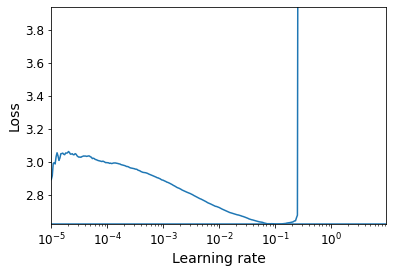

In [151]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [152]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [153]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 7ms/step - loss: 2.2398 - accuracy: 0.2309 - val_loss: 1.7721 - val_accuracy: 0.3778
Epoch 2/15
352/352 [==============================] - 2s 6ms/step - loss: 1.7947 - accuracy: 0.3664 - val_loss: 1.6650 - val_accuracy: 0.4178
Epoch 3/15
352/352 [==============================] - 2s 7ms/step - loss: 1.6358 - accuracy: 0.4239 - val_loss: 1.6489 - val_accuracy: 0.4242
Epoch 4/15
352/352 [==============================] - 2s 7ms/step - loss: 1.5402 - accuracy: 0.4557 - val_loss: 1.6302 - val_accuracy: 0.4398
Epoch 5/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4850 - accuracy: 0.4767 - val_loss: 1.6161 - val_accuracy: 0.4368
Epoch 6/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4328 - accuracy: 0.4902 - val_loss: 1.5974 - val_accuracy: 0.4416
Epoch 7/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4013 - accuracy: 0.5013 - val_loss: 1.5453 - val_accuracy: 0.4590
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.